In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
from sklearn import linear_model
from sklearn.calibration import CalibratedClassifierCV

In [2]:
#mounting the dataset from drive
from google.colab import drive
drive.mount('/content/gdrive') 

#connecting to sqlite db
con = sqlite3.connect('database.sqlite')
                      
# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [0]:
print(display.shape)
display.head()

(80668, 7)


UserId   ProductId             ProfileName        Time  Score  \
0  #oc-R115TNMSPFT9I7  B007Y59HVM                 Breyton  1331510400      2   
1  #oc-R11D9D7SHXIJB9  B005HG9ET0  Louis E. Emory "hoppy"  1342396800      5   
2  #oc-R11DNU2NBKQ23Z  B007Y59HVM        Kim Cieszykowski  1348531200      1   
3  #oc-R11O5J5ZVQE25C  B005HG9ET0           Penguin Chick  1346889600      5   
4  #oc-R12KPBODL2B5ZD  B007OSBE1U   Christopher P. Presta  1348617600      1   

                                                Text  COUNT(*)  
0  Overall its just OK when considering the price...         2  
1  My wife has recurring extreme muscle spasms, u...         3  
2  This coffee is horrible and unfortunately not ...         2  
3  This will be the bottle that you grab from the...         3  
4  I didnt like this coffee. Instead of telling y...         2

In [27]:
# Removing duplicate reviews
final=filtered_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
print(final.shape)

(100000, 13)


In [28]:
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

100.0

In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [30]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(100000, 13)


1    87729
0    12271
Name: Score, dtype: int64

In [31]:
final["cleanReview"] = final["Summary"].map(str) + ". " + final["Text"]
final['cleanReview'].head()

117924    EVERY book is educational. this witty little b...
117901    This whole series is great way to spend time w...
298792    Entertainingl Funny!. Beetlejuice is a well wr...
169281    A modern day fairy tale. A twist of rumplestis...
298791    FANTASTIC!. Beetlejuice is an excellent and fu...
Name: cleanReview, dtype: object

In [32]:
final['lengthOfReview'] = final['cleanReview'].str.split().str.len()
final['lengthOfReview'].head()

117924    78
117901    90
298792    31
169281    41
298791    44
Name: lengthOfReview, dtype: int64

In [0]:
#remove urls from text python
from tqdm import tqdm
lst = []
removed_urls_list = []
for text in tqdm(final['Text']):
  removed_urls_text = re.sub(r"http\S+", "", text)
  lst.append(removed_urls_text)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 364171/364171 [00:01<00:00, 313040.89it/s]


In [0]:
#remove urls from text python
removed_urls_list = []
for text in tqdm(lst):
  removed_urls_text = re.sub(r"http\S+", "", text)
  removed_urls_list.append(removed_urls_text)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 364171/364171 [00:01<00:00, 343430.96it/s]


In [0]:
from bs4 import BeautifulSoup
text_lst = []
for text in tqdm(removed_urls_list):
  soup = BeautifulSoup(text, 'lxml')
  text = soup.get_text()
  text_lst.append(text)
# print(text)
# print("="*50)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 364171/364171 [02:16<00:00, 2662.25it/s]


In [0]:
print(len(final['Text']))

364171


In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [0]:
decat_lst = []
for decat_text in tqdm(text_lst):
  text = decontracted(decat_text)
  decat_lst.append(text)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 364171/364171 [00:06<00:00, 53616.87it/s]


In [0]:
strip_list = []
for to_strip in tqdm(decat_lst):
  text = re.sub("\S*\d\S*", "", to_strip).strip()
  strip_list.append(text)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 364171/364171 [00:30<00:00, 11914.41it/s]


In [0]:
spatial_list = []
for to_spatial in tqdm(strip_list):
  text = re.sub('[^A-Za-z0-9]+', ' ', to_spatial)
  spatial_list.append(text)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 364171/364171 [00:20<00:00, 18059.44it/s]


In [0]:
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [0]:
# Combining all the above stundents 
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(spatial_list):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 364171/364171 [03:37<00:00, 1671.64it/s]


In [0]:
print(len(preprocessed_reviews))
preprocessed_reviews[-1]

364171


'satisfied product advertised use cereal raw vinegar general sweetner'

In [0]:
final['Preprocessed_text'] = preprocessed_reviews

In [0]:
print(len(final))
final.tail(5)

364171


Id   ProductId          UserId              ProfileName  \
525809  568450  B001EO7N10  A28KG5XORO54AY         Lettie D. Carter   
525810  568451  B003S1WTCU  A3I8AFVPEE8KI5                R. Sawyer   
525811  568452  B004I613EE  A121AA1GQV751Z            pksd "pk_007"   
525812  568453  B004I613EE   A3IBEVCTXKNOH  Kathy A. Welch "katwel"   
525813  568454  B001LR2CU2  A3LGQPJCZVL9UC                 srfell17   

        HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
525809                     0                       0      1  1299628800   
525810                     0                       0      0  1331251200   
525811                     2                       2      1  1329782400   
525812                     1                       1      1  1331596800   
525813                     0                       0      1  1338422400   

                                   Summary  \
525809                 Will not do without   
525810                        disappointed   
525811            Perfect for our maltipoo   
525812  Favorite Training and reward treat   
525813                         Great Honey   

                                                     Text  \
525809  Great for sesame chicken..this is a good if no...   
525810  I'm disappointed with the flavor. The chocolat...   
525811  These stars are small, so you can give 10-15 o...   
525812  These are the BEST treats for training and rew...   
525813  I am very satisfied ,product is as advertised,...   

                                              cleanReview  lengthOfReview  \
525809  Will not do without. Great for sesame chicken....              30   
525810  disappointed. I'm disappointed with the flavor...              47   
525811  Perfect for our maltipoo. These stars are smal...              70   
525812  Favorite Training and reward treat. These are ...              40   
525813  Great Honey. I am very satisfied ,product is a...              23   

                                        Preprocessed_text  
525809  great sesame chicken good not better resturant...  
525810  disappointed flavor chocolate notes especially...  
525811  stars small give one training session tried tr...  
525812  best treats training rewarding dog good groomi...  
525813  satisfied product advertised use cereal raw vi...

In [2]:
dir_path = os.getcwd()
# conn = sqlite3.connect(os.path.join(dir_path, '/content/gdrive/My Drive/Colab Notebooks/SVM/final.sqlite'))
conn = sqlite3.connect(os.path.join(dir_path, 'final.sqlite'))
# final.to_sql('Reviews', conn, if_exists='replace', index=False)

In [3]:
review_3 = pd.read_sql_query(""" SELECT count(*) FROM Reviews""", conn)
print(review_3)

   count(*)
0    364171


In [4]:
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews""", conn)

In [5]:
filtered_data.shape

(364171, 12)

In [6]:
filtered_data["Time"] = pd.to_datetime(filtered_data["Time"], unit = "s")
filtered_data = filtered_data.sort_values(by = "Time")

In [7]:
filtered_data.head(5)

Id   ProductId          UserId               ProfileName  \
117924  150524  0006641040   ACITT7DI6IDDL           shari zychinski   
117901  150501  0006641040   AJ46FKXOVC7NR        Nicholas A Mesiano   
298792  451856  B00004CXX9   AIUWLEQ1ADEG5          Elizabeth Medina   
169281  230285  B00004RYGX  A344SMIA5JECGM           Vincent P. Ross   
298791  451855  B00004CXX9   AJH6LUC1UT1ON  The Phantom of the Opera   

        HelpfulnessNumerator  HelpfulnessDenominator  Score       Time  \
117924                     0                       0      1 1999-10-08   
117901                     2                       2      1 1999-10-25   
298792                     0                       0      1 1999-12-02   
169281                     1                       2      1 1999-12-06   
298791                     0                       0      1 2000-01-03   

                                                  Summary  \
117924                          EVERY book is educational   
117901  This whole series is great way to spend time w...   
298792                               Entertainingl Funny!   
169281                            A modern day fairy tale   
298791                                         FANTASTIC!   

                                                     Text  \
117924  this witty little book makes my son laugh at l...   
117901  I can remember seeing the show when it aired o...   
298792  Beetlejuice is a well written movie ..... ever...   
169281  A twist of rumplestiskin captured on film, sta...   
298791  Beetlejuice is an excellent and funny movie. K...   

                                              cleanReview  lengthOfReview  
117924  every book educational witty little book makes...              38  
117901  whole series great way spend time child rememb...              39  
298792  entertainingl funny beetlejuice well written m...              15  
169281  modern day fairy tale twist rumplestiskin capt...              25  
298791  fantastic beetlejuice excellent funny movie ke...              26

In [8]:
print(len(filtered_data))
filtered_data.info()
filtered_data = filtered_data.head(100000)
print(len(filtered_data))

364171
<class 'pandas.core.frame.DataFrame'>
Int64Index: 364171 entries, 117924 to 107253
Data columns (total 12 columns):
Id                        364171 non-null int64
ProductId                 364171 non-null object
UserId                    364171 non-null object
ProfileName               364171 non-null object
HelpfulnessNumerator      364171 non-null int64
HelpfulnessDenominator    364171 non-null int64
Score                     364171 non-null int64
Time                      364171 non-null datetime64[ns]
Summary                   364171 non-null object
Text                      364171 non-null object
cleanReview               364171 non-null object
lengthOfReview            364171 non-null int64
dtypes: datetime64[ns](1), int64(5), object(6)
memory usage: 36.1+ MB
100000


In [9]:
filtered_data['Score'].value_counts()

1    87729
0    12271
Name: Score, dtype: int64

In [10]:
X = filtered_data["cleanReview"]
print(print("shape of X:", X.head(5)))
y = filtered_data["Score"]
print("shape of y:", y.head(5))
X_len = filtered_data['lengthOfReview']

shape of X: 117924    every book educational witty little book makes...
117901    whole series great way spend time child rememb...
298792    entertainingl funny beetlejuice well written m...
169281    modern day fairy tale twist rumplestiskin capt...
298791    fantastic beetlejuice excellent funny movie ke...
Name: cleanReview, dtype: object
None
shape of y: 117924    1
117901    1
298792    1
169281    1
298791    1
Name: Score, dtype: int64


In [11]:
len(filtered_data['lengthOfReview'])

100000

In [12]:
X_train = X[0:60000]
Y_train = y[0:60000]
X_val = X[60000:80000]
Y_val = y[60000:80000]
X_test = X[80000:100000]
Y_test = y[80000:100000]

In [13]:
print(len(X_train), len(X_test), len(X_val))
print(len(Y_train), len(Y_test), len(Y_val))

60000 20000 20000
60000 20000 20000


# [4.1] BAG OF WORDS

In [44]:
from sklearn.feature_extraction.text import CountVectorizer 

count_vect = CountVectorizer()
X_train_vect = count_vect.fit_transform(X_train)
X_test_vect = count_vect.transform(X_test)
X_val_vect = count_vect.transform(X_val)
feature_names = count_vect.get_feature_names()
# BoW_dict = {'X_train_vect':X_train_vect, 'X_test_vect': X_test_vect, 'X_val_vect': X_val_vect}
print(X_train_vect.shape)
# print(feature_names)

(60000, 47535)


In [0]:
X_train_vect.shape

(60000, 48270)

In [0]:
len(final['lengthOfReview'])

364171

In [0]:
from scipy.sparse import hstack
# len_review = final['lengthOfReview'].to_sparse()
concat_data = hstack((X_train_vect,np.array(final['lengthOfReview'][0:60000])[:,None]))
concat_data_val = hstack((X_val_vect,np.array(final['lengthOfReview'][60000:80000])[:,None]))
concat_data_test = hstack((X_test_vect,np.array(final['lengthOfReview'][80000:100000])[:,None]))

In [0]:
print(concat_data.shape)
print(concat_data_val.shape)
print(concat_data_test.shape)

(60000, 48271)
(20000, 48271)
(20000, 48271)


In [0]:
print(len(feature_names))

48270


In [0]:
BoW_dict = {'X_train_vect':concat_data, 'X_test_vect': concat_data_test, 'X_val_vect': concat_data_val}
print(BoW_dict['X_train_vect'].shape)

(60000, 48271)


In [0]:
import pickle
with open('BoW.pkl', 'wb') as handle:
    pickle.dump(BoW_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

# [4.3] TF-IDF

In [94]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
train_tf_idf = tf_idf_vect.fit_transform(X_train)
cv_tf_idf = tf_idf_vect.transform(X_val)
test_tf_idf = tf_idf_vect.transform(X_test)

print("the shape of out text TFIDF vectorizer ",train_tf_idf.get_shape())
print("the type of count vectorizer ",type(train_tf_idf))
print("the number of unique words including both unigrams and bigrams ", train_tf_idf.get_shape()[1])

the shape of out text TFIDF vectorizer  (60000, 35873)
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the number of unique words including both unigrams and bigrams  35873


In [176]:
from scipy.sparse import hstack
tfidf_concat_data_train = hstack((train_tf_idf,np.array(filtered_data['lengthOfReview'][0:60000])[:,None]))
tfidf_concat_data_val = hstack((cv_tf_idf,np.array(filtered_data['lengthOfReview'][60000:80000])[:,None]))
tfidf_concat_data_test = hstack((test_tf_idf,np.array(filtered_data['lengthOfReview'][80000:100000])[:,None]))

In [177]:
tf_idf_dict = {'train_tf_idf': tfidf_concat_data_train, 'cv_tf_idf': tfidf_concat_data_val, 'test_tf_idf': tfidf_concat_data_test}

In [178]:
import pickle
with open('tf_idf.pkl', 'wb') as handle:
    pickle.dump(tf_idf_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

# [4.4] Word2Vec

In [241]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sen=[]
for sentance in X_train:
    list_of_sen.append(sentance.split())

In [242]:
is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sen,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('fantastic', 0.9040200710296631), ('wonderful', 0.8998451232910156), ('good', 0.8745156526565552), ('terrific', 0.8421463966369629), ('nice', 0.7987102270126343), ('fabulous', 0.7933881282806396), ('perfect', 0.7839844226837158), ('excellent', 0.7502694129943848), ('delicious', 0.7368237972259521), ('decent', 0.7319214344024658)]
[('best', 0.8560127019882202), ('greatest', 0.8049135208129883), ('tastiest', 0.7658340930938721), ('closest', 0.7615100145339966), ('BEST', 0.7247588634490967), ('best-tasting', 0.7184524536132812), ('smoothest', 0.6995263695716858), ('best.', 0.69404137134552), ('Best', 0.6918725967407227), ('finest', 0.678147554397583)]


In [243]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  32552
sample words  ['lime', 'brave', 'cheapest.', 'Bariani', 'digests', 'news,', 'shipping,', 'Nice,', 'notice', 'poppy', "Oreo's", 'sites', "ISN'T", 'crack', 'oatmeal.<br', 'defrost', 'discovers', 'Jerky,', '"pill', 'bears', 'scarfed', 'make.', 'gravy', 'forced', 'robust.', 'NY,', 'Kellogs', 'try!', 'sauteed', "Dave's", 'Le', 'chalk.', 'Biscotti.', 'unless', 'Geyser', 'PRIME', 'factor,', 'describe', 'applying', 'reasons.', 'the', 'Highland', 'layer', 'Use', 'Retrievers', 'considering.', '/>it', 'planet,', 'Aroma', 'objects']


# [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

# [4.4.1.1] Avg W2v

In [244]:
print(X_train[117924])
print(len(X_val))
print(len(X_test))

EVERY book is educational. this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
20000
20000


In [0]:
# average Word2Vec
# compute average word2vec for each review.
def avg_w2vec(sentences_received):
    sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in tqdm(sentences_received): # for each review/sentence
        sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        sent_vectors.append(sent_vec)

    print(len(sent_vectors))
    print(len(sent_vectors[0]))
    return sent_vectors

In [0]:
print(len([sent.split() for sent in X_test]))

20000


In [0]:
avg_w2v_train = avg_w2vec([sent.split() for sent in X_train])
avg_w2v_cv = avg_w2vec([sent.split() for sent in X_val])
avg_w2v_test = avg_w2vec([sent.split() for sent in X_test])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 60000/60000 [1:26:58<00:00, 11.50it/s]


60000
50


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [30:10<00:00, 11.05it/s]


20000
50


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [26:46<00:00, 12.45it/s]


20000
50


In [0]:
Avg_w2v_dict = {'X_train_avgw2v':avg_w2v_train, 'Y_train_avgw2v': Y_train,  
                     'X_val_avgw2v': avg_w2v_cv, 'Y_val_avgw2v': Y_val,
                    'X_test_avgw2v': avg_w2v_test, 'Y_test_avgw2v': Y_test}

In [0]:
import pickle
with open('avg_w2v.pkl', 'wb') as handle:
    pickle.dump(Avg_w2v_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

# [4.4.1.2] TFIDF weighted W2v

In [245]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [246]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

def tfidf_w2v(sentences_received):
    tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
    row=0;
    for sent in tqdm(sentences_received): # for each review/sentence 
        sent_vec = np.zeros(50) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words and word in tfidf_feat:
                vec = w2v_model.wv[word]
    #             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
                # to reduce the computation we are 
                # dictionary[word] = idf value of word in whole courpus
                # sent.count(word) = tf valeus of word in this review
                tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
        row += 1
        
    return tfidf_sent_vectors

In [ ]:
tfidf_w2v_train = tfidf_w2v([sent.split() for sent in X_train])
tfidf_w2v_cv = tfidf_w2v([sent.split() for sent in X_val])
tfidf_w2v_test = tfidf_w2v([sent.split() for sent in X_test])

In [0]:
tfidf_w2v_dict = {'X_train_tfidfw2v':tfidf_w2v_train, 'Y_train_tfidfw2v': Y_train,  
                     'X_val_tfidfw2v': tfidf_w2v_cv, 'Y_val_tfidfw2v': Y_val,
                    'X_test_tfidfw2v': tfidf_w2v_test, 'Y_test_tfidfw2v': Y_test}

In [0]:
with open('tfidf_w2v.pkl', 'wb') as handle:
    pickle.dump(tfidf_w2v_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

# RandomForest on BoW

In [15]:
import pickle
# with open(r"/content/gdrive/My Drive/Colab Notebooks/SVM/BoW.pkl", "rb") as input_file:
with open(r"BoW.pkl", "rb") as input_file:
    BoW_dict = pickle.load(input_file)

In [16]:
from scipy.sparse import vstack
X_train_val = vstack((BoW_dict['X_train_vect'], BoW_dict['X_val_vect']))

In [17]:
Y_train_val = pd.concat([Y_train, Y_val], axis= 0)

In [18]:
Y_train_val.shape

(80000,)

In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
bow_lgr_train_score_list = []
bow_lgr_val_score_list = []
fpr = dict()
tpr = dict()
fpr_val = dict()
tpr_val = dict()
roc_auc_train = dict()
roc_auc_val = dict()
roc_auc_test = dict()
fpr_list = []
tpr_list = []

param_grid = {
    'max_depth': [4, 8, 16, 32],
    'n_estimators': [1, 2, 5, 10, 50, 100, 200]
#     'max_depth': [1, 2],
#     'n_estimators': [1, 2]
}

rf = RandomForestClassifier(n_jobs=-1)
clf = GridSearchCV(estimator = rf, param_grid = param_grid, scoring = 'roc_auc')
clf.fit(X_train_val,Y_train_val)

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [4, 8, 16, 32], 'n_estimators': [1, 2, 5, 10, 50, 100, 200]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [35]:
f = clf.cv_results_
f

{'mean_fit_time': array([ 1.08788006,  0.75307171,  0.18696578,  0.22663546,  0.44639317,
         0.77667141,  1.38383563,  0.18881726,  0.19400509,  0.22994566,
         0.2959586 ,  0.77160692,  1.33400408,  2.40471093,  0.24769727,
         0.25510001,  0.30735517,  0.42971174,  1.40639901,  2.5017724 ,
         4.76029706,  0.39719121,  0.39728332,  0.48856521,  0.78400588,
         2.78265127,  5.27796419, 10.22126778]),
 'mean_score_time': array([0.02872181, 0.12287903, 0.12272406, 0.12580276, 0.12676501,
        0.12601821, 0.22476061, 0.0242157 , 0.12186416, 0.12368997,
        0.12422164, 0.12518469, 0.12562935, 0.22573558, 0.02552334,
        0.12258609, 0.12377818, 0.12458936, 0.12556632, 0.2262667 ,
        0.2927498 , 0.02835703, 0.12291423, 0.12441468, 0.12537758,
        0.12518477, 0.22570141, 0.32652442]),
 'mean_test_score': array([0.51811462, 0.53781774, 0.65529341, 0.72373935, 0.83423645,
        0.88185225, 0.88483601, 0.54858665, 0.59229105, 0.72252846,
        0

In [36]:
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
import numpy as np

In [37]:
x1_list = []
x2_list = []
for c1 in clf.cv_results_['params']:
    x1_list.append(c1['n_estimators'])
for c2 in clf.cv_results_['params']:
    x2_list.append(c2['max_depth'])
print(x1_list, x2_list)

[1, 2, 5, 10, 50, 100, 200, 1, 2, 5, 10, 50, 100, 200, 1, 2, 5, 10, 50, 100, 200, 1, 2, 5, 10, 50, 100, 200] [4, 4, 4, 4, 4, 4, 4, 8, 8, 8, 8, 8, 8, 8, 16, 16, 16, 16, 16, 16, 16, 32, 32, 32, 32, 32, 32, 32]


In [38]:
x1 = x1_list
y1 = x2_list
z1 = clf.cv_results_['mean_train_score'].tolist()
x2 = x1_list
y2 = x2_list
z2 = clf.cv_results_['mean_test_score'].tolist()

In [39]:
# https://plot.ly/python/3d-axes/
trace1 = go.Scatter3d(x=x1,y=y1,z=z1, name = 'train')
trace2 = go.Scatter3d(x=x2,y=y2,z=z2, name = 'Cross validation')
data = [trace1, trace2]

layout = go.Layout(scene = dict(
        xaxis = dict(title='n_estimators'),
        yaxis = dict(title='max_depth'),
        zaxis = dict(title='AUC'),))

fig = go.Figure(data=data, layout=layout)
offline.iplot(fig, filename='3d-scatter-colorscale')

In [40]:
clf.best_params_

{'max_depth': 32, 'n_estimators': 200}

In [41]:
best_max_depth = clf.best_params_['max_depth']
best_n_estimators = clf.best_params_['n_estimators']

In [42]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(max_depth = best_max_depth, n_estimators=best_n_estimators, n_jobs=-1)
rf_clf.fit(BoW_dict['X_train_vect'],Y_train)
bow_test_proba = rf_clf.predict_proba(BoW_dict['X_test_vect'])
bow_train_proba = rf_clf.predict_proba(BoW_dict['X_train_vect'])
bow_test_proba

array([[0.07043014, 0.92956986],
       [0.18155246, 0.81844754],
       [0.16671903, 0.83328097],
       ...,
       [0.10687981, 0.89312019],
       [0.06625853, 0.93374147],
       [0.21271111, 0.78728889]])

In [75]:
print("Top 20 Important Features")
d = sorted(list(zip(count_vect.get_feature_names(), rf_clf.feature_importances_ )), key=lambda x: x[1], reverse=True)[:20]
features_list = []
for (i,j) in d:
    features_list.append(i)

Top 20 Important Features


In [46]:
bow_fpr_train, bow_tpr_train, _ = roc_curve(Y_train, bow_train_proba[:, 1])
bow_fpr_test, bow_tpr_test, _ = roc_curve(Y_test, bow_test_proba[:, 1])
bow_test_auc = auc(bow_fpr_test, bow_tpr_test)
bow_train_auc = auc(bow_fpr_train, bow_tpr_train)
print(bow_test_auc)
print(bow_train_auc)

0.9259647916660196
0.9776043421979128


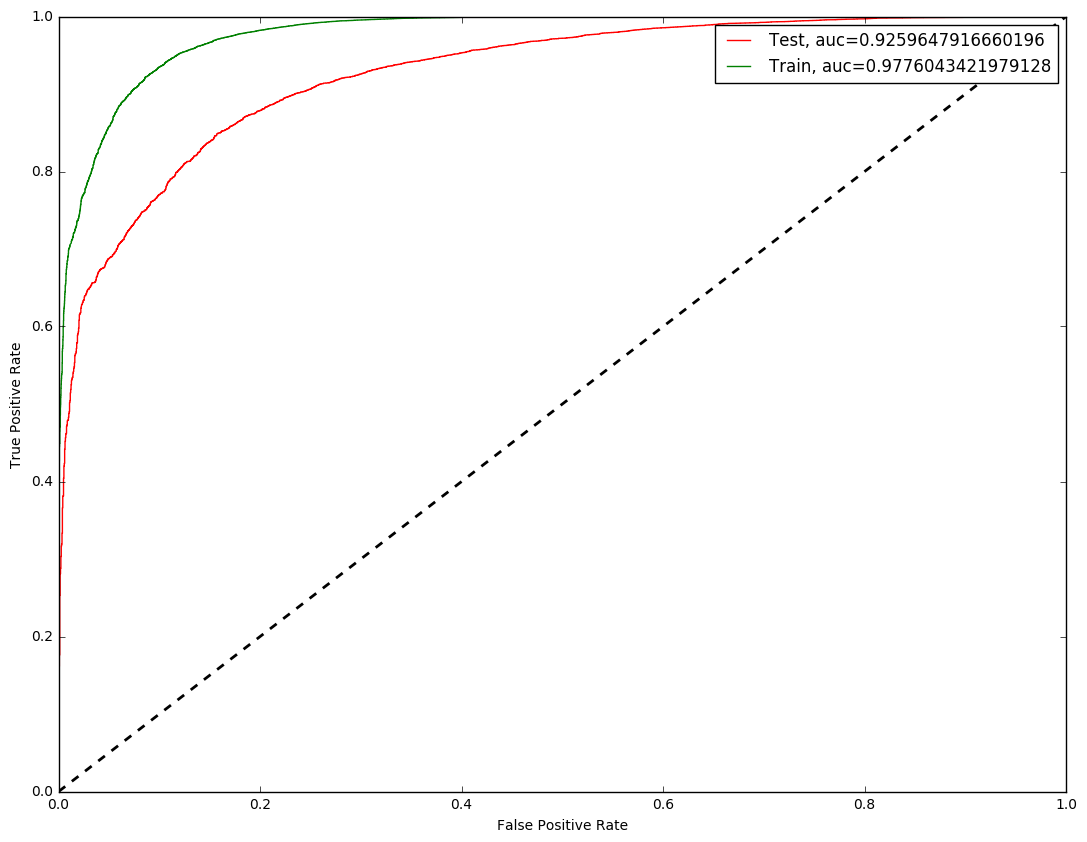

In [47]:
import pylab
plt.figure(figsize=(13, 10))
plt.plot([0,1], [0,1], color='black', lw=2, linestyle='--')
plt.plot(bow_fpr_test, bow_tpr_test, label="Test, auc="+str(bow_test_auc), color = 'red')
plt.plot(bow_fpr_train, bow_tpr_train, label="Train, auc="+str(bow_train_auc), color = 'green')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.show()

In [48]:
bow_test_conf = rf_clf.predict(BoW_dict['X_test_vect'])
bow_train_conf = rf_clf.predict(BoW_dict['X_train_vect'])

In [49]:
from sklearn.metrics import classification_report, confusion_matrix
bow_train_conf_matrix = confusion_matrix(Y_train, bow_train_conf)
bow_test_conf_matrix = confusion_matrix(Y_test, bow_test_conf)
class_report = classification_report(Y_test, bow_test_conf)
print(bow_test_conf_matrix)
print(class_report)

[[    4  2672]
 [    0 17324]]
              precision    recall  f1-score   support

           0       1.00      0.00      0.00      2676
           1       0.87      1.00      0.93     17324

   micro avg       0.87      0.87      0.87     20000
   macro avg       0.93      0.50      0.47     20000
weighted avg       0.88      0.87      0.80     20000



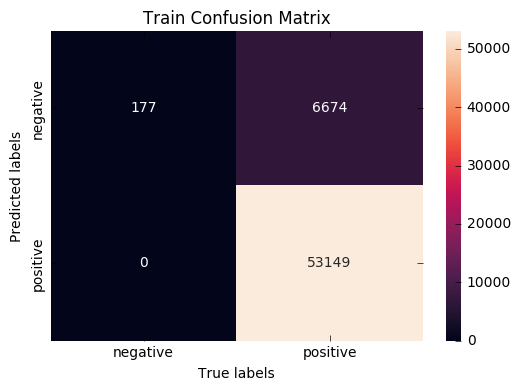

In [50]:
ax= plt.subplot()
sns.heatmap(bow_train_conf_matrix, annot=True, ax = ax, fmt='g')

ax.set_ylabel('Predicted labels')
ax.set_xlabel('True labels')
ax.set_title('Train Confusion Matrix') 
ax.xaxis.set_ticklabels(['negative', 'positive']) 
ax.yaxis.set_ticklabels(['negative', 'positive'])

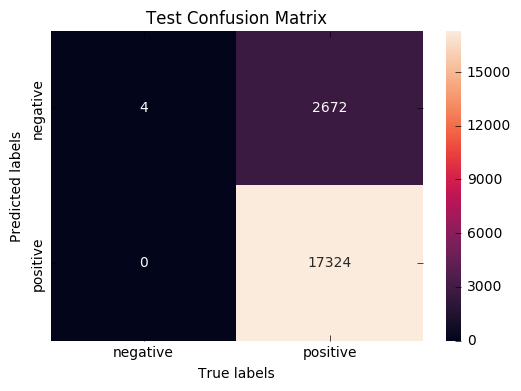

In [51]:
ax= plt.subplot()
sns.heatmap(bow_test_conf_matrix, annot=True, ax = ax, fmt='g')

ax.set_ylabel('Predicted labels')
ax.set_xlabel('True labels')
ax.set_title('Test Confusion Matrix') 
ax.xaxis.set_ticklabels(['negative', 'positive']) 
ax.yaxis.set_ticklabels(['negative', 'positive'])

In [80]:
complete_string = '-'.join(features_list)

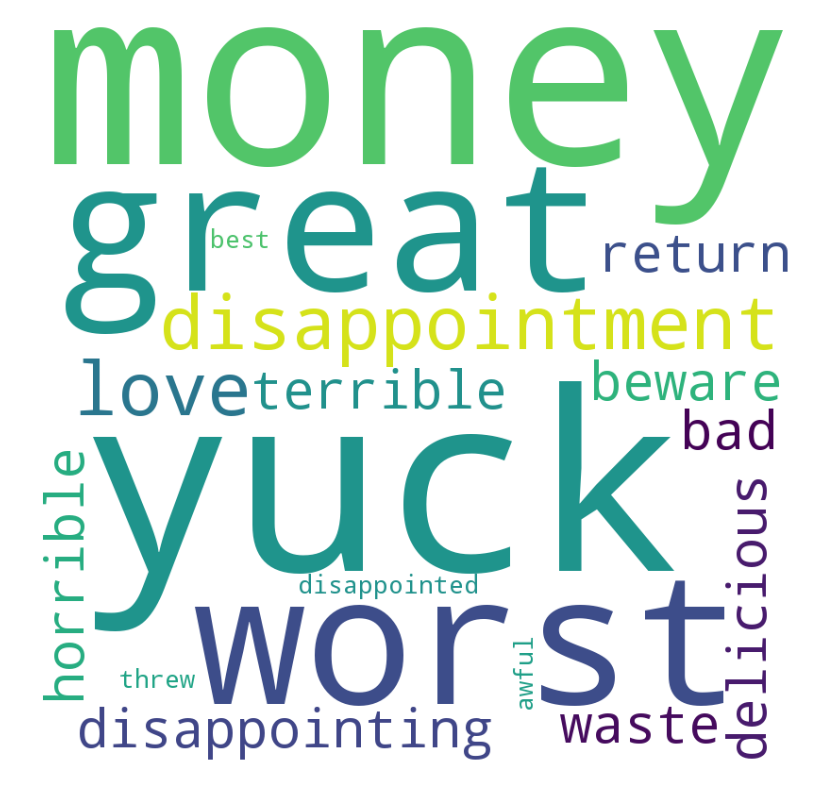

In [81]:
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 
  
stopwords = set(STOPWORDS) 

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(complete_string) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

# Random Forest on Tf-IDF

In [82]:
import pickle
with open(r"tf_idf.pkl", "rb") as input_file:
    tfidf_dict = pickle.load(input_file)

In [83]:
from scipy.sparse import vstack
X_train_val_tfidf = vstack((tfidf_dict['train_tf_idf'], tfidf_dict['cv_tf_idf']))

In [84]:
print(X_train_val_tfidf.shape)

(80000, 35874)


In [85]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [4, 8, 16, 32],
    'n_estimators': [1, 2, 5, 10, 50, 100, 200]
}

rf = RandomForestClassifier(n_jobs=-1)
tfidf_clf = GridSearchCV(estimator = rf, param_grid = param_grid, scoring = 'roc_auc')
tfidf_clf.fit(X_train_val_tfidf,Y_train_val)

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [4, 8, 16, 32], 'n_estimators': [1, 2, 5, 10, 50, 100, 200]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [86]:
tfidf_results = tfidf_clf.cv_results_
tfidf_results

{'mean_fit_time': array([1.04127208, 0.8077991 , 0.21802235, 0.23593307, 0.4302427 ,
        0.56491256, 0.943645  , 0.21072404, 0.21103938, 0.23648858,
        0.26187269, 0.53134529, 0.78394103, 1.29907147, 0.23221087,
        0.23209818, 0.26744501, 0.32847174, 0.78485608, 1.30189085,
        2.31605649, 0.30317505, 0.30900137, 0.36630861, 0.47732766,
        1.46055317, 2.62855935, 4.96681929]),
 'mean_score_time': array([0.03721499, 0.13364983, 0.13180304, 0.13280725, 0.1350042 ,
        0.23591391, 0.33532842, 0.03491871, 0.13157821, 0.13282919,
        0.13379161, 0.13433059, 0.23562368, 0.33529576, 0.03540047,
        0.13171498, 0.13276887, 0.13436214, 0.13487045, 0.23537135,
        0.33527501, 0.03705748, 0.13184524, 0.13336229, 0.13478462,
        0.13527656, 0.23494236, 0.36913292]),
 'mean_test_score': array([0.52700338, 0.57332015, 0.60255122, 0.7042028 , 0.87066479,
        0.89287245, 0.90787459, 0.57915731, 0.63757597, 0.72802821,
        0.79208698, 0.89929969, 0.911

In [88]:
tfidf_x_list = []
tfidf_y_list = []
for c1 in tfidf_clf.cv_results_['params']:
    tfidf_x_list.append(c1['n_estimators'])
for c2 in tfidf_clf.cv_results_['params']:
    tfidf_y_list.append(c2['max_depth'])
print(tfidf_x_list, tfidf_y_list)

[1, 2, 5, 10, 50, 100, 200, 1, 2, 5, 10, 50, 100, 200, 1, 2, 5, 10, 50, 100, 200, 1, 2, 5, 10, 50, 100, 200] [4, 4, 4, 4, 4, 4, 4, 8, 8, 8, 8, 8, 8, 8, 16, 16, 16, 16, 16, 16, 16, 32, 32, 32, 32, 32, 32, 32]


In [89]:
x1 = tfidf_x_list
y1 = tfidf_y_list
z1 = tfidf_clf.cv_results_['mean_train_score'].tolist()
x2 = tfidf_x_list
y2 = tfidf_y_list
z2 = tfidf_clf.cv_results_['mean_test_score'].tolist()

In [90]:
# https://plot.ly/python/3d-axes/
trace1 = go.Scatter3d(x=x1,y=y1,z=z1, name = 'train')
trace2 = go.Scatter3d(x=x2,y=y2,z=z2, name = 'Cross validation')
data = [trace1, trace2]

layout = go.Layout(scene = dict(
        xaxis = dict(title='n_estimators'),
        yaxis = dict(title='max_depth'),
        zaxis = dict(title='AUC'),))

fig = go.Figure(data=data, layout=layout)
offline.iplot(fig, filename='3d-scatter-colorscale')

In [91]:
tfidf_clf.best_params_

{'max_depth': 32, 'n_estimators': 200}

In [92]:
tfidf_best_max_depth = tfidf_clf.best_params_['max_depth']
tfidf_best_n_estimators = tfidf_clf.best_params_['n_estimators']

In [99]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(max_depth = tfidf_best_max_depth, n_estimators=tfidf_best_n_estimators, n_jobs=-1)
rf_clf.fit(tfidf_dict['train_tf_idf'],Y_train)
tfidf_test_proba = rf_clf.predict_proba(tfidf_dict['test_tf_idf'])
tfidf_train_proba = rf_clf.predict_proba(tfidf_dict['train_tf_idf'])
tfidf_test_proba

array([[0.06929329, 0.93070671],
       [0.23496998, 0.76503002],
       [0.10822995, 0.89177005],
       ...,
       [0.10162364, 0.89837636],
       [0.06253476, 0.93746524],
       [0.27811993, 0.72188007]])

In [100]:
print("Top 20 Important Features")
d = sorted(list(zip(tf_idf_vect.get_feature_names(), rf_clf.feature_importances_ )), key=lambda x: x[1], reverse=True)[:20]
features_list_tfidf = []
for (i,j) in d:
    features_list_tfidf.append(i)

Top 20 Important Features


In [101]:
tfidf_fpr_train, tfidf_tpr_train, _ = roc_curve(Y_train, tfidf_train_proba[:, 1])
tfidf_fpr_test, tfidf_tpr_test, _ = roc_curve(Y_test, tfidf_test_proba[:, 1])
tfidf_test_auc = auc(tfidf_fpr_test, tfidf_tpr_test)
tfidf_train_auc = auc(tfidf_fpr_train, tfidf_tpr_train)
print(tfidf_test_auc)
print(tfidf_train_auc)

0.9375346103058598
0.9839738874085514


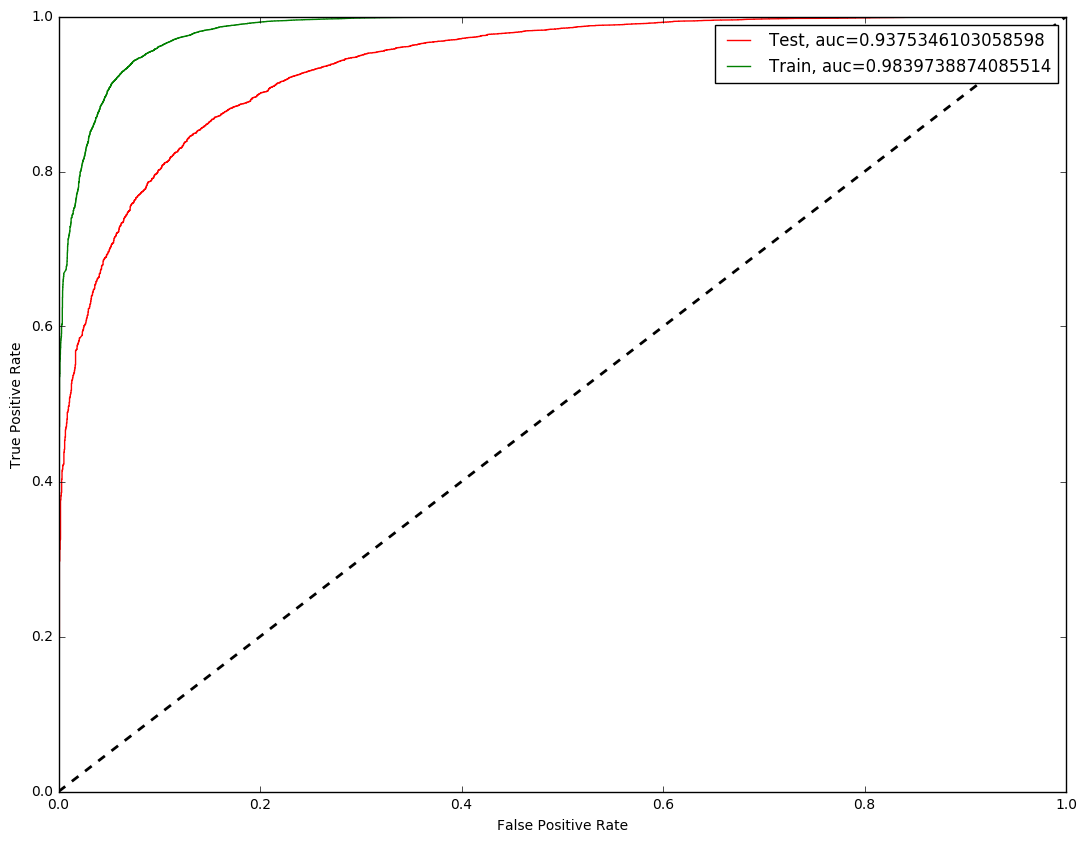

In [102]:
import pylab
plt.figure(figsize=(13, 10))
plt.plot([0,1], [0,1], color='black', lw=2, linestyle='--')
plt.plot(tfidf_fpr_test, tfidf_tpr_test, label="Test, auc="+str(tfidf_test_auc), color = 'red')
plt.plot(tfidf_fpr_train, tfidf_tpr_train, label="Train, auc="+str(tfidf_train_auc), color = 'green')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.show()

In [103]:
tfidf_test_conf = tfidf_clf.predict(tfidf_dict['test_tf_idf'])
tfidf_train_conf = tfidf_clf.predict(tfidf_dict['train_tf_idf'])

In [104]:
from sklearn.metrics import classification_report, confusion_matrix
tfidf_train_conf_matrix = confusion_matrix(Y_train, tfidf_train_conf)
tfidf_test_conf_matrix = confusion_matrix(Y_test, tfidf_test_conf)
class_report = classification_report(Y_test, tfidf_test_conf)
print(tfidf_test_conf_matrix)
print(class_report)

[[   51  2625]
 [    0 17324]]
              precision    recall  f1-score   support

           0       1.00      0.02      0.04      2676
           1       0.87      1.00      0.93     17324

   micro avg       0.87      0.87      0.87     20000
   macro avg       0.93      0.51      0.48     20000
weighted avg       0.89      0.87      0.81     20000



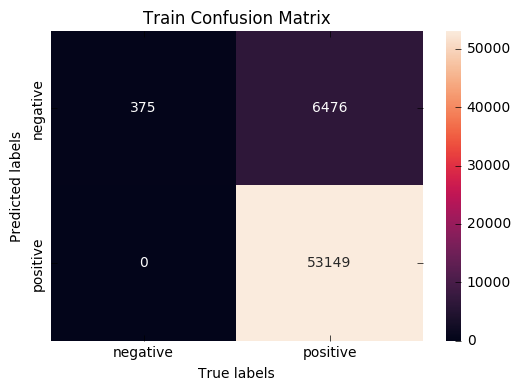

In [105]:
ax= plt.subplot()
sns.heatmap(tfidf_train_conf_matrix, annot=True, ax = ax, fmt='g')

ax.set_ylabel('Predicted labels')
ax.set_xlabel('True labels')
ax.set_title('Train Confusion Matrix') 
ax.xaxis.set_ticklabels(['negative', 'positive']) 
ax.yaxis.set_ticklabels(['negative', 'positive'])

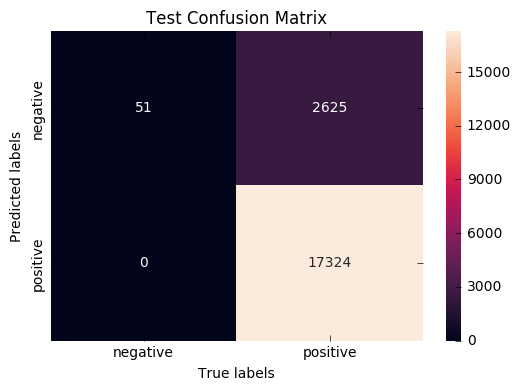

In [106]:
ax= plt.subplot()
sns.heatmap(tfidf_test_conf_matrix, annot=True, ax = ax, fmt='g')

ax.set_ylabel('Predicted labels')
ax.set_xlabel('True labels')
ax.set_title('Test Confusion Matrix') 
ax.xaxis.set_ticklabels(['negative', 'positive']) 
ax.yaxis.set_ticklabels(['negative', 'positive'])

In [107]:
complete_string_tfidf = '-'.join(features_list_tfidf)

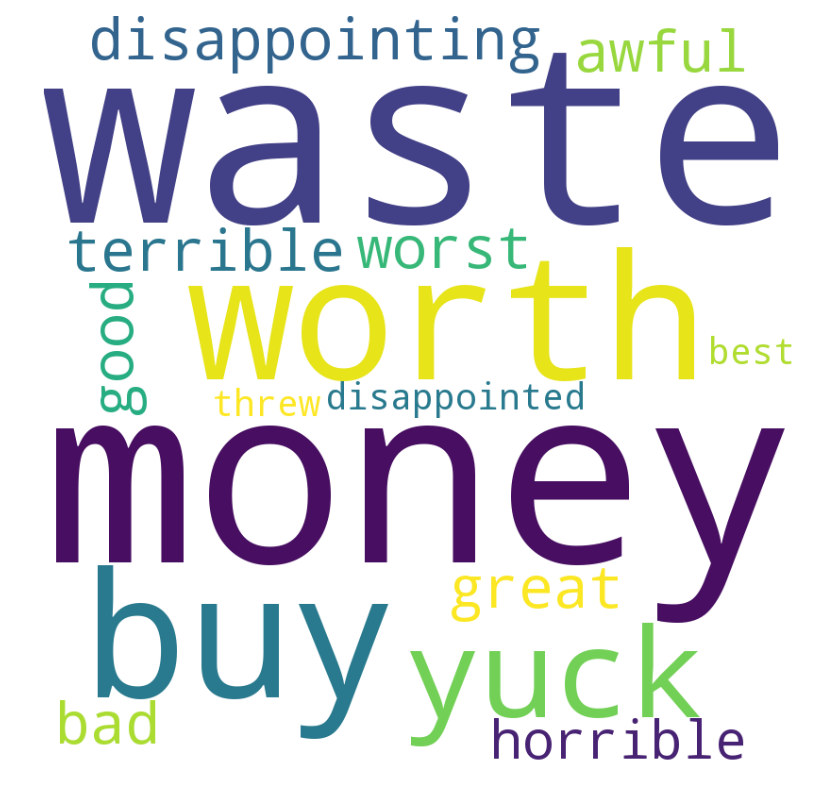

In [108]:
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 
  
stopwords = set(STOPWORDS) 

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(complete_string_tfidf) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()